# 1.  Importar a Biblioteca

In [126]:
# Importando os pacotes a serem utilizados
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import sklearn.metrics.pairwise as pw
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity



# 2. Carregando os arquivos

In [127]:
filmes = pd.read_csv('Filmes.csv', sep=',', low_memory = False)
ratings = pd.read_csv('ratings.csv', sep=',')

In [128]:
dados = pd.read_csv('Dados.csv')
tags = pd.read_csv('Tags.csv')

# 3. TRATATIVA DOS DADOS

In [129]:
ratings = ratings.drop_duplicates()
filmes = filmes.drop_duplicates()

In [130]:
# Filtrar para usuários com mais de 100 avaliações
active_users = ratings.groupby('userId').size() > 999
ratings_filtered = ratings[ratings['userId'].isin(active_users.index)]

# Amostra aleatória de 20%
ratings = ratings_filtered.sample(frac=0.2)

# Converter a coluna 'year' para inteiro (se necessário)
filmes['year'] = filmes['year'].astype(str).str.extract(r'(\d+)')
filmes['year'] = pd.to_numeric(filmes['year'], errors='coerce')

# Filtrar para filmes lançados após 2010
filmes = filmes[filmes['year'] >= 2010]

Demonstrando os Dataframes

In [131]:
filmes.head(2)

,movieId,title,genres,year
7216,73268,Daybreakers,Action|Drama|Horror|Thriller,2010.0
7218,73319,Leap Year,Comedy|Romance,2010.0


In [132]:
ratings.head(2)

,userId,movieId,rating,timestamp
6684632,69050,922,5.0,1344798531
21066427,218915,410,4.0,1159948065


In [133]:
dados.head(2)

,Name,Year,Stars,Score,Time,Votes,Total,Tags,Directors_Cast,Discription
0,Pulp Fiction,1994,8.9,94.0,154,"1,871,051",$107.93,\nCrime Drama,Quentin Tarantino John Travolta Uma Thurman Sa...,\nThe lives of two mob hitmen a boxer a gangst...
1,The Amazing Spider-Man 2,2014,6.6,53.0,142,"425,529",$202.85,\nAction Adventure Fantasy,Marc Webb Andrew Garfield Emma Stone Jamie Fox...,\nWhen New York is put under siege by Oscorp i...


In [134]:
tags.head(2)

,movieId,tag
0,1,"Owned,imdb top 250,Pixar,Pixar,time travel,chi..."
1,2,"Robin Williams,time travel,fantasy,based on ch..."


Preparação 1

In [135]:
df = filmes.merge(ratings, on='movieId')
df = df[['title','movieId', 'userId', 'rating', 'year']]
df.head(2)

,title,movieId,userId,rating,year
0,Daybreakers,73268,187438,2.0,2010.0
1,Daybreakers,73268,223656,3.5,2010.0


Preparação 2

In [136]:
filmes['movieId'] = filmes['movieId'].apply(lambda x: str(x))

df2 = filmes.merge(dados, left_on='title', right_on='Name', how='left')
df2 = df2.merge(tags, left_on='movieId', right_on='movieId', how='left')
df2['Infos'] = df2['genres'] + str(df2['Directors_Cast']) + str(df2['Discription']) + df2['tag']
df2.head(2)

,movieId,title,genres,year,Name,Year,Stars,Score,Time,Votes,Total,Tags,Directors_Cast,Discription,tag,Infos
0,73268,Daybreakers,Action|Drama|Horror|Thriller,2010.0,Daybreakers,2009,6.4,57.0,98,"123,683",$30.10,\nAction Adventure Fantasy,Michael Spierig Peter Spierig Ethan Hawke Will...,\nIn the year 2019 a plague has transformed al...,"vampires,Willem Dafoe,dystopia,epidemic,experi...",Action|Drama|Horror|Thriller0 Michael Sp...
1,73319,Leap Year,Comedy|Romance,2010.0,Leap Year,2010,6.5,33.0,100,"98,434",$25.92,\nComedy Romance,Anand Tucker Amy Adams Matthew Goode Adam Scot...,\nAnna Brady plans to travel to Dublin Ireland...,"Amy Adams,Ireland,Amy Adams,airplane,bar,cardi...",Comedy|Romance0 Michael Spierig Peter Sp...


# 4. ANÁLISE EXPLORATÓRIA DOS DADOS

In [137]:
# Inspecionar os dados
print(df.describe())

             movieId         userId         rating           year
count  347090.000000  347090.000000  347090.000000  347090.000000
mean   102883.662422  135085.364617       3.584333    2012.469109
std     21476.905167   78472.239150       1.026586       1.919900
min     73268.000000       1.000000       0.500000    2010.000000
25%     86880.000000   66016.000000       3.000000    2011.000000
50%     98203.000000  134805.000000       3.500000    2012.000000
75%    112788.000000  203110.000000       4.500000    2014.000000
max    175743.000000  270894.000000       5.000000    2017.000000


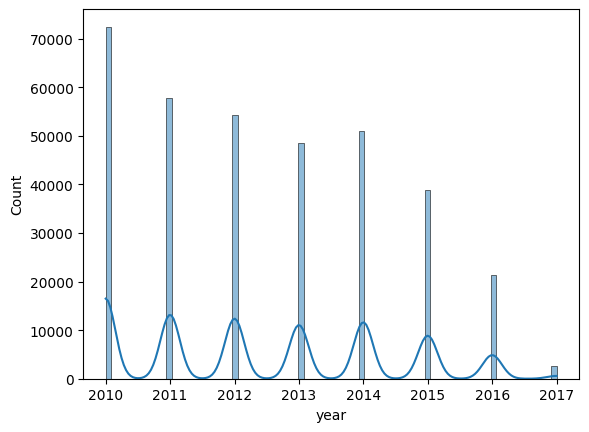

In [138]:
# Análise univariada
sns.histplot(df['year'], kde=True)
plt.show()

Rejeitamos a hipótese nula. Existe uma correlação significativa entre year e rating.
Correlação entre year e rating: 0.012900622068758198


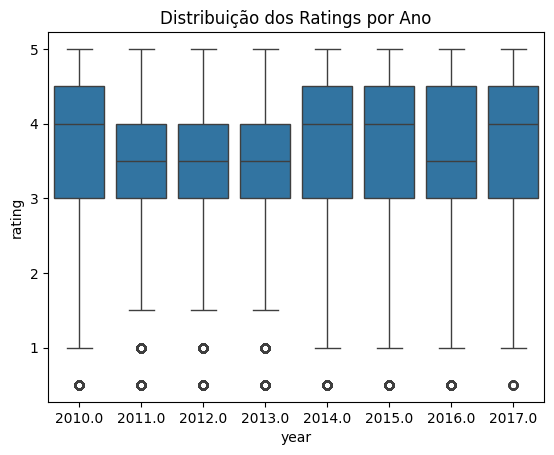

In [139]:
# Análise de correlação
correlation = df['year'].corr(df['rating'])

# Calculando o coeficiente de correlação de Pearson
corr_coef, p_value = stats.pearsonr(df['year'], df['rating'])

# Definindo o nível de significância (usualmente 5%)
alpha = 0.05

# Tomando a decisão
if p_value < alpha:
    print("Rejeitamos a hipótese nula. Existe uma correlação significativa entre year e rating.")
else:
    print("Não podemos rejeitar a hipótese nula. Não há evidência suficiente para afirmar que existe uma correlação significativa.")
    
sns.boxplot(x='year', y='rating', data=df)
plt.title('Distribuição dos Ratings por Ano')
print("Correlação entre year e rating:", correlation)
plt.show()

# 4. MODELOS

Modelo 1

In [140]:
tabela_filmes = pd.pivot_table(df, index='title', columns='userId', values='rating').fillna(0)

In [141]:
rec = pw.cosine_similarity(tabela_filmes)
rec_df = pd.DataFrame(rec, columns=tabela_filmes.index, index=tabela_filmes.index)
rec_df.head(2)

title,'71,'Tis the Season for Love,10 Cent Pistol,10 Cloverfield Lane,10 Years,100 Streets,12 Years a Slave,127 Hours,13 Assassins (Jûsan-nin no shikaku),13 Hours,...,Zero Dark Thirty,"Zero Theorem, The",Zipper,Zombeavers,Zookeeper,Zoolander 2,Zoom,Zootopia,Zulu,[REC]³ 3 Génesis
title,,,,,,,,,,,,,,,,,,,,,
'71,1.0,0.0,0.0,0.051728,0.0,0.0,0.021264,0.021151,0.01094,0.039636,...,0.037591,0.000000,0.10597,0.0,0.006215,0.0,0.0,0.014069,0.0,0.0
'Tis the Season for Love,0.0,1.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.089652,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


In [142]:
df['id'] = range(1, len(df) + 1)

In [143]:
df.head()

,title,movieId,userId,rating,year,id
0,Daybreakers,73268,187438,2.0,2010.0,1
1,Daybreakers,73268,223656,3.5,2010.0,2
2,Daybreakers,73268,17273,3.0,2010.0,3
3,Daybreakers,73268,38087,2.5,2010.0,4
4,Daybreakers,73268,137565,4.0,2010.0,5


Modelo 2

In [179]:
vec = TfidfVectorizer()
tfidf = vec.fit_transform(df2['Infos'].apply(lambda x: np.str_(x)))

sim = cosine_similarity(tfidf)
sim

sim_df2 = pd.DataFrame(sim, columns=df2['title'], index=df2['title'])
sim_df2.head(2)

title,Daybreakers,Leap Year,"Book of Eli, The",Legion,When in Rome,Temple Grandin,Valentine's Day,"Wolfman, The",Shutter Island,Percy Jackson & the Olympians: The Lightning Thief,...,Gintama,Gintama: The Movie,anohana: The Flower We Saw That Day - The Movie,Silver Spoon,Love Live! The School Idol Movie,Jon Stewart Has Left the Building,Black Butler: Book of the Atlantic,No Game No Life: Zero,Flint,Bungo Stray Dogs: Dead Apple
title,,,,,,,,,,,,,,,,,,,,,
Daybreakers,1.000000,0.038773,0.143752,0.022062,0.022644,0.054788,0.011948,0.028085,0.018234,0.017713,...,0.054788,0.061599,0.054788,0.054788,0.054788,0.054788,0.054788,0.054788,0.054788,0.071576
Leap Year,0.038773,1.000000,0.012892,0.088140,0.216689,0.270282,0.063487,0.082041,0.008230,0.040134,...,0.270282,0.315570,0.270282,0.270282,0.270282,0.270282,0.270282,0.270282,0.270282,0.356024


Engenharia de Features

In [145]:
# Engenharia de features
df['média_notas_usuário'] = df.groupby('userId')['rating'].transform('mean')
df['média_notas_filme'] = df.groupby('movieId')['rating'].transform('mean')
df['num_filmes_avaliados'] = df.groupby('userId')['movieId'].transform('count')

In [146]:

X = df[['média_notas_usuário', 'média_notas_filme', 'num_filmes_avaliados', 'id']]
y = df['rating']

In [147]:
# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [148]:
# Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [149]:
# Criar e treinar o modelo
modelo = RandomForestRegressor(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [178]:
# Fazer previsões
y_pred = modelo.predict(X_test)
y_pred

array([3.97 , 4.165, 4.425, ..., 3.675, 4.565, 1.785])

In [151]:
# Avaliar o modelo
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

RMSE: 0.8099042507705306


# 5. Buscando Filmes

Previsão Modelo 1

In [197]:
print("As recomendações para o filme Thor do Modelo 1 estão representadas na Tabela Abaixo")
cossine_df = pd.DataFrame(rec_df['Iron Man 3'].sort_values(ascending=False))
cossine_df.columns = ['Recomendações']
cossine_df.head(20)

As recomendações para o filme Thor do Modelo 1 estão representadas na Tabela Abaixo


,Recomendações
title,
Iron Man 3,1.000000
Iron Man 2,0.130197
Thor,0.128988
Avengers: Age of Ultron,0.116831
"Avengers, The",0.114025
Man of Steel,0.111191
Captain America: The Winter Soldier,0.109570
Thor: The Dark World,0.108987
"Wolverine, The",0.108411


Previsão Modelo 2

In [198]:
print("As recomendações para o filme Thor do Modelo 2 estão representadas na Tabela Abaixo")
final_df = pd.DataFrame(sim_df2['Iron Man 3'].sort_values(ascending=False))
final_df.columns = ['Recomendações']
final_df.head(20)

As recomendações para o filme Thor do Modelo 2 estão representadas na Tabela Abaixo


,Recomendações
title,
Iron Man 3,1.000000
Iron Man 2,0.714059
"Avengers, The",0.649896
Avengers: Infinity War - Part I,0.451466
Sherlock Holmes: A Game of Shadows,0.427560
Avengers: Age of Ultron,0.418104
Captain America: Civil War,0.408267
"Judge, The",0.399062
Due Date,0.398890


In [154]:
# Exploração dos dados

<Figure size 2000x1000 with 0 Axes>

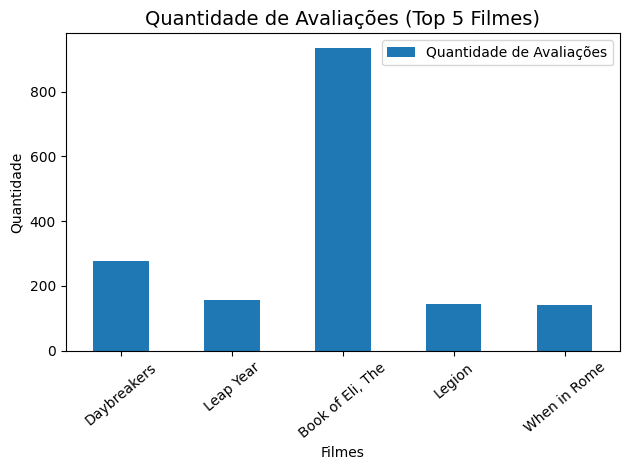

In [171]:
# Configurando o estilo do gráfico
plt.figure(figsize=(20, 10))

# Selecionar os 10 primeiros filmes com base na ordem dos títulos
top_5_filmes = df['title'].unique()[:5]

# Filtrar o DataFrame para conter apenas os 10 primeiros filmes
df_top_5 = df[df['title'].isin(top_5_filmes)]

# Contar a quantidade de avaliações para os 10 primeiros filmes
avaliacoes_por_filme = df_top_5.groupby('title')['rating'].count().reset_index()
avaliacoes_por_filme.columns = ['title', 'quantidade_avaliacoes']

# Mesclar com o DataFrame principal para associar o title e a quantidade de tags
df_merged = df_top_5[['title', 'movieId']].drop_duplicates()

# Mesclar as quantidades de avaliações e tags para os 10 primeiros filmes
df_comparativo = df_merged.merge(avaliacoes_por_filme, on='title', how='left').fillna(0)

# Plotar o gráfico de barras para comparar quantidade de avaliações e tags
df_comparativo.set_index('title')[['quantidade_avaliacoes']].plot(kind='bar')

# Definir título e rótulos
plt.title('Quantidade de Avaliações (Top 5 Filmes)', fontsize=14)
plt.xlabel('Filmes')
plt.ylabel('Quantidade')
plt.xticks(rotation=40)
plt.legend(['Quantidade de Avaliações'])

# Mostrar o gráfico
plt.tight_layout()
plt.show()

In [183]:
# Exemplo de definição de y_true e y_pred
import pandas as pd

# Digamos que esses sejam os rótulos verdadeiros e previsões (como exemplo)
y_true = pd.Series([1, 0, 1, 0, 1], index=[0, 1, 2, 3, 4])
recomendacoes_conteudo = pd.Series([1, 0, 1, 1, 0], index=[0, 2, 4, 1, 3])

def precision_at_k(y_true, y_pred, k=10):
    # Função que calcula a precisão em k
    y_pred_top_k = y_pred.head(k).index
    relevant_items = set(y_true.head(k).index)
    recommended_items = set(y_pred_top_k)
    
    # Precisão = itens relevantes recomendados / número total de recomendações
    precision = len(recommended_items.intersection(relevant_items)) / k
    return precision

# Avaliação da precisão em k para o Modelo 2
precision_k_modelo2 = precision_at_k(y_true, recomendacoes_conteudo, k=10)
print(f"Precisão@10 do Modelo 2 (Conteúdo): {precision_k_modelo2}")


Precisão@10 do Modelo 2 (Conteúdo): 0.5
